combine N stocks via PCA, autoencoder, averaging the normalized signal 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
!pip install yfinance
import yfinance as yf # https://github.com/ranaroussi/yfinance


from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
# spx,nasdaq, ....DJI other indexes 

# SPX = yf.Ticker("INX").history(period='20y')
# QQQ = yf.Ticker("^IXIC").history(period='20y')
# DJI = yf.Ticker("^DJI").history(period='20y')


df = pd.DataFrame({
                  'spx':yf.Ticker("^GSPC").history(period='20y')["Close"]
                  ,'nas':yf.Ticker("^IXIC").history(period='20y')["Close"]
                  ,'dji':yf.Ticker("^DJI").history(period='20y')["Close"]
                  ,'rut':yf.Ticker("^RUT").history(period='20y')["Close"]
                # ,'UKX':yf.Ticker("^FTSE").history(period='20y')["Close"]  # UKX == ^FTSE                 
                          }).dropna()
df.head(10)

#normalized_df=(df-df.mean())/df.std() # mean 
normalized_df=(df-df.min())/(df.max()-df.min()) # min - max 


,spx,nas,dji,rut
Date,,,,
2002-05-06,1052.670044,1578.479980,9808.040039,502.910004
2002-05-07,1049.489990,1573.819946,9836.549805,498.980011
2002-05-08,1088.849976,1696.290039,10141.830078,509.750000
2002-05-09,1073.010010,1650.489990,10037.419922,501.390015
2002-05-10,1054.989990,1600.849976,9939.919922,492.730011
2002-05-13,1074.560059,1652.540039,10109.660156,499.720001
2002-05-14,1097.280029,1719.050049,10298.139648,511.720001
2002-05-15,1091.069946,1725.560059,10243.679688,513.539978
2002-05-16,1098.229980,1730.439941,10289.209961,507.399994


# Data visualization

<AxesSubplot:xlabel='Date'>

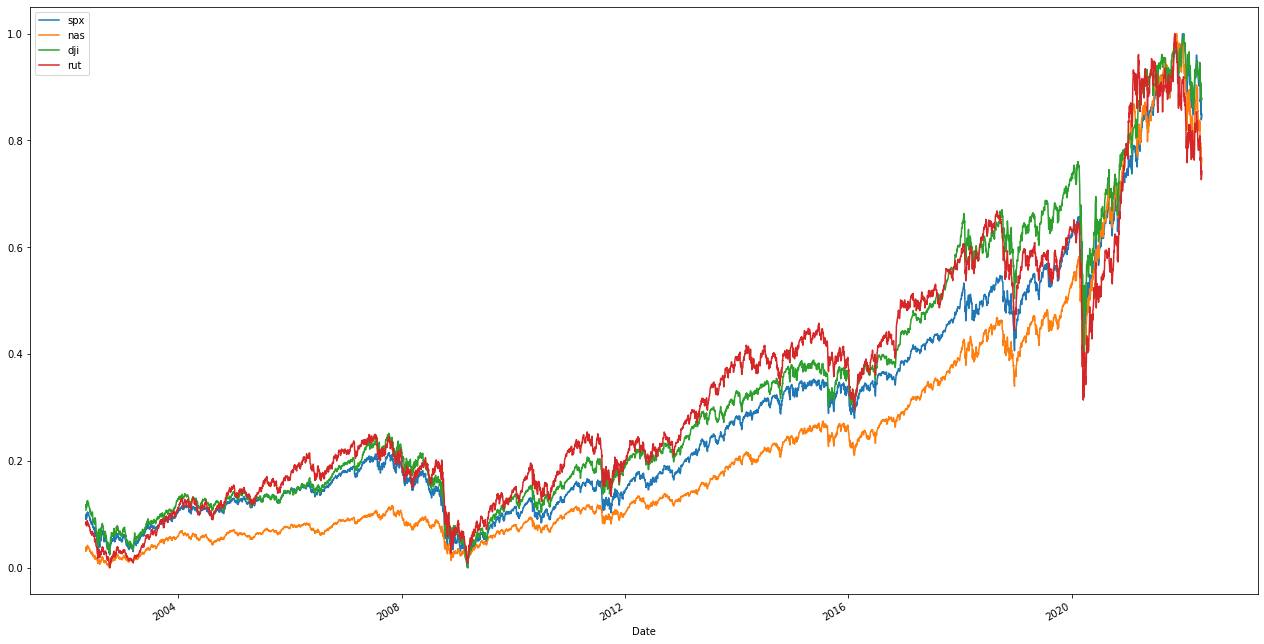

In [3]:
normalized_df.plot(figsize=(22,12), use_index=True)

In [4]:
# x= spy.close.values # ndarray 
# X = x.reshape(-1,1)

In [5]:
def sample_MSE_implementation(df):
    from sklearn.metrics import mean_squared_error
    Matrix = [[round(mean_squared_error(df.iloc[:, row],df.iloc[:, col]),6) for row in range(df.columns.size)] for col in range(df.columns.size)] 
    return pd.DataFrame(Matrix, columns=df.columns, index=df.columns)
sample_MSE_implementation(normalized_df)

,spx,nas,dji,rut
spx,0.000000,0.004285,0.002339,0.003685
nas,0.004285,0.000000,0.011384,0.013411
dji,0.002339,0.011384,0.000000,0.002171
rut,0.003685,0.013411,0.002171,0.000000


In [6]:
def sample_MAE_implementation(df):
    from sklearn.metrics import mean_absolute_error
    Matrix = [[round(mean_absolute_error(df.iloc[:, row],df.iloc[:, col]),6) for row in range(df.columns.size)] for col in range(df.columns.size)] 
    return pd.DataFrame(Matrix, columns=df.columns, index=df.columns)
sample_MAE_implementation(normalized_df)

,spx,nas,dji,rut
spx,0.000000,0.059670,0.036907,0.051159
nas,0.059670,0.000000,0.094069,0.103496
dji,0.036907,0.094069,0.000000,0.035471
rut,0.051159,0.103496,0.035471,0.000000


In [7]:
normalized_df.corr()

,spx,nas,dji,rut
spx,1.000000,0.990526,0.993893,0.978775
nas,0.990526,1.000000,0.978330,0.959610
dji,0.993893,0.978330,1.000000,0.983320
rut,0.978775,0.959610,0.983320,1.000000


Data looks very well similar given the
* Mean squared error 
* Mean absolute error
* Correlation (pearson)  

C:\Users\alik604\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\alik604\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


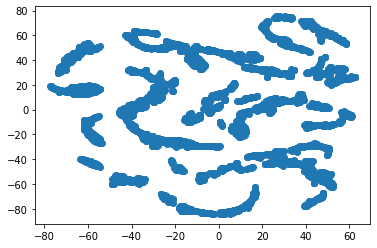

In [8]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(normalized_df.values)
plt.scatter(X_embedded[:,0],X_embedded[:,1])

Well that looks useless.... I stand be my current opinion, dimensionality reduction for data visualization of time series is nothing more that self-pleasuring  

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(normalized_df.values)
X_pca = pca.fit_transform(normalized_df.values)

PCA(n_components=2)

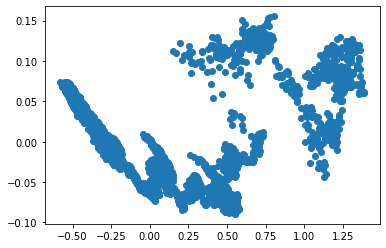

In [10]:
plt.scatter(X_pca[:,0],X_pca[:,1],)

In [11]:
print(pca.components_)


[[ 0.48952248  0.49806977  0.52596631  0.48544173]
 [ 0.17522566  0.67127028 -0.14827939 -0.7047733 ]]


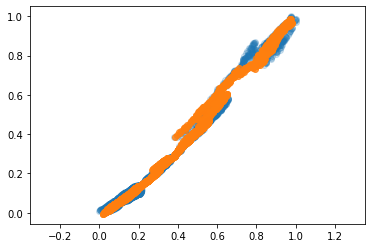

In [12]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(normalized_df.values[:, 0], normalized_df.values[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

# let's try reducing Dimentionality with a *Autoencoder* 

In [15]:
# from https://blog.keras.io/building-autoencoders-in-keras.html
from keras.layers import Input, Dense, BatchNormalization,LSTM,RepeatVector
from keras.models import Model


len(normalized_df.columns)

4

## Deep autoencoder


In [80]:
import gc
gc.collect()

10379

In [81]:
dim = 2
encoding_dim = len(normalized_df.columns) 
input_window = Input(shape=(encoding_dim,))


# encoded = Dense(3, activation='relu')(input_img)
# encoded = Dense(dim, activation='relu')(input_img)
# encoder = Model(input_img, encoded)
# decoded = Dense(encoding_dim, activation='sigmoid')(encoded) 
# autoencoder = Model(input_img, decoded)
# encoded_input = Input(shape=(dim,))
# decoder_layer = autoencoder.layers[-1]
# decoder = Model(encoded_input, decoder_layer(encoded_input))
##############################################################################


x = Dense(3, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(2, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(3, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(encoding_dim, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

# autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='MAE') # binary_crossentropy
history = autoencoder.fit(values, values,
                epochs=5,
                batch_size=8,
                shuffle=True,
                validation_split=0.2)


Epoch 1/5
504/504 [==============================] - 2s 2ms/step - loss: 0.1447 - val_loss: 0.4164
Epoch 2/5
504/504 [==============================] - 1s 1ms/step - loss: 0.0484 - val_loss: 0.3385
Epoch 3/5
504/504 [==============================] - 1s 1ms/step - loss: 0.0436 - val_loss: 0.3111
Epoch 4/5
504/504 [==============================] - 1s 1ms/step - loss: 0.0440 - val_loss: 0.2384
Epoch 5/5
504/504 [==============================] - 1s 1ms/step - loss: 0.0415 - val_loss: 0.2363


158/158 [==============================] - 0s 1ms/step


<AxesSubplot:>

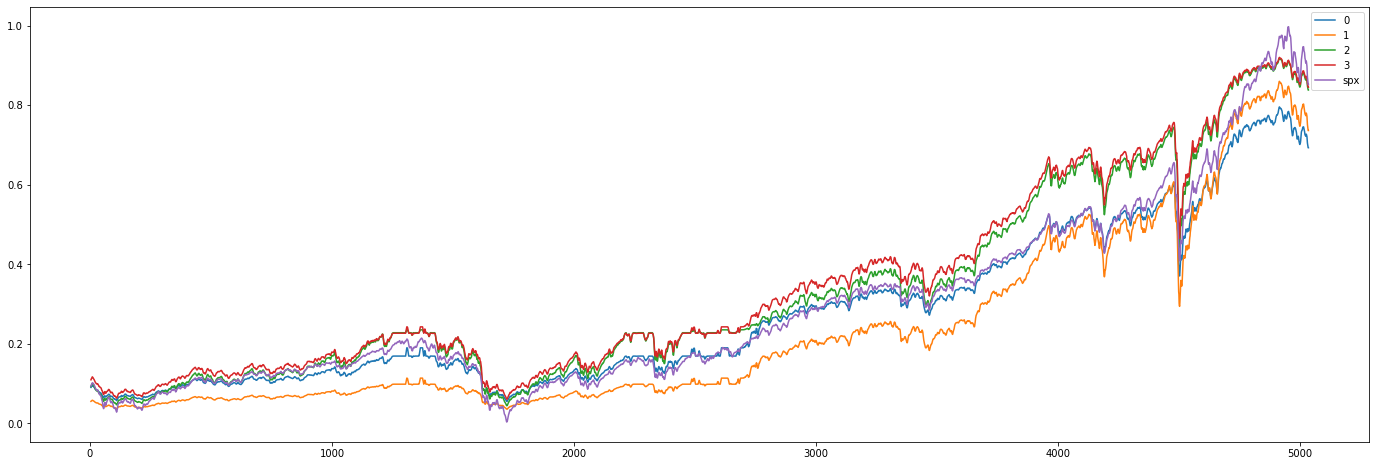

In [63]:
#autoencoder.fit(values,values,epochs=5)
yhat = autoencoder.predict(values, verbose=1)
myDict = {
'0':np.transpose(yhat)[0],
'1':np.transpose(yhat)[1],
'2':np.transpose(yhat)[2],
'3':np.transpose(yhat)[3],
'spx':normalized_df.spx.values}

tmp = pd.DataFrame(myDict)
tmp = tmp.rolling(5).mean()
tmp.plot(figsize=(24,8))

<AxesSubplot:>

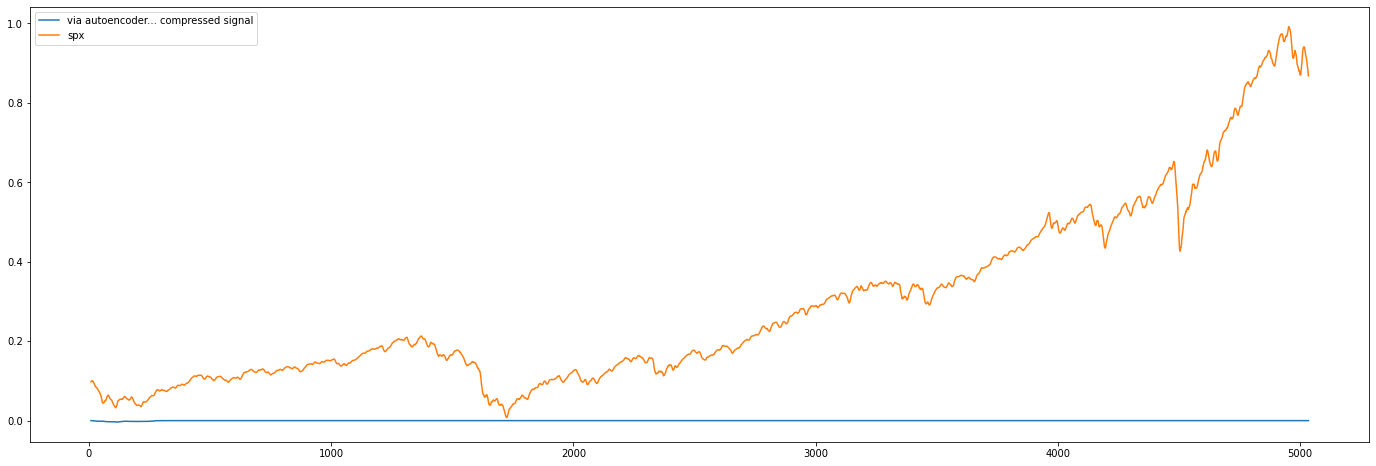

In [83]:
myDict = {'via autoencoder... compressed signal':np.transpose(yhat)[1],
          'spx':normalized_df.spx.values
}

tmp = pd.DataFrame(myDict)
tmp = tmp.rolling(10).mean()
tmp.plot(figsize=(24,8))

## 1D convolutional autoencoder